In [1]:
library(TreePar)
library(TreeSim)
library(NELSI)
library(doParallel)
library(foreach)

Loading required package: ape
Loading required package: Matrix
Loading required package: subplex
Loading required package: TreeSim
Loading required package: laser
Loading required package: geiger
Loading required package: deSolve

Attaching package: ‘deSolve’

The following object is masked from ‘package:graphics’:

    matplot

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel


## Diversification model adequacy: empirical data with two rate shifts

In this example I fit and underparameterised model to a a set of trees. In particular I generate a set of ten trees under a rate-shift model with two rate shifts. These trees are refered to here as the 'empirical' trees. I estimate $\lambda$ and $\mu$ under a zero rate-shift model for each tree and use these parameters to simulate 100 trees. For each of the simulated trees, I find it's maximum likelihood under a zero rate-shift model, generating the expectation of the likelihoods if the model used to analyse the data matches the true model. Because the 'emprical' trees were simulated under a different model, their likelihood should be lower than that of the trees simulated under the correct model.

In [2]:
set.seed(10)
nspecies <- 100
time <- c(0, 0.5, 1) # At time 1 and 0.5 in the past, there are rate shifts
rho <- c(0.5, 1, 1) #half of the present day species are sampled (rho[1] = 0.5)
lambda <- c(1.5, 15, 2)# speciation rates, between t[i] and t[i+1] we have a speciation rate lambda
mu <- c(1.5, 1.5, 1.5)# extinction rate. Similar notation as lambda

rateshift_trees <- sim.rateshift.taxa(nspecies, 10, lambda = lambda, mu = mu, frac = rho, times = time, complete = F)

- This function fits a rate shifts model with up to two rate changes, and returns $\lambda$ and $\mu$, calculated from the turnover and net speciation rate for different numbers of rate shifts. In this example I am only using one rate shift.

In [3]:
fit_rate_shifts <- function(tree, rho){ # Rho at present.

    x_times <- sort(intnode.times(tree), decreasing = T)
    start <- min(x_times)
    end <- max(x_times)
    grid <- diff(range(x_times))
    res <- bd.shifts.optim(x_times, c(rho, 1, 1), grid, start, end, posdiv = T)[[2]]

    # Find likelihoods, lambda, mu, and rate-shift times
    likelihoods <- sapply(res, function(x) x[1]) 
    
    lambda0 <- res[[1]][3] / (1 - res[[1]][2]) # These are the lambda and mu estimates from turover and net 
    mu0 <- lambda0 * res[[1]][2]               # speciation for 0 rate shifts. Please check.
   
    # The following are also computed, but note that some of them are negative and that this might. 
    # I couldn't simulate trees using these parameters, maybe because of the negative values?
    lambda11 <- res[[2]][3] / (1 - res[[2]][2])
    mu11 <- lambda11 * res[[2]][2]
    lambda12 <- res[[2]][5] / (1 - res[[2]][4])
    mu12 <- lambda12 * res[[2]][4]
    time1 <- res[[2]][length(res[[2]])]
        
    lambda21 <- res[[3]][3] / (1 - res[[3]][2])
    mu21 <- lambda21 * res[[2]][2]
    lambda22 <- res[[3]][5] / (1 - res[[3]][4])
    mu22 <- lambda22 * res[[3]][4]
    lambda23 <- res[[3]][7] / (1 - res[[3]][6])
    mu23 <- lambda23 * res[[3]][6]
    time2 <- res[[3]][(length(res[[3]]) - 2):length(res[[3]])]
    
    return(list(likelihoods, shifts0= c(lambda0, mu0), shifts1=c(lambda11, lambda12, mu11, mu12, time1), 
               shifts2=c(lambda21, lambda22, lambda23, mu21, mu22, mu23, time2)))
}

- In the followig loop, I iterate through all the 'emprical' trees. For each tree, I estimate $\lambda$ and $\mu$. I then use these values to simulate 100 trees. For each simulated tree I calculate the maximum likelihood to use as a null distribution.

In [4]:
pvals <- vector()
likelihoods_distros <- list()
likelihoods_empirical <- vector()
empirical_tree_param_estimates <- list()

cl <- makeCluster(8)
registerDoParallel(cl)
for(tr in 1:length(rateshift_trees)){
    x_times <- sort(intnode.times(rateshift_trees[[tr]]), decreasing = T)
    start <- min(x_times)
    end <- max(x_times)
    grid <- diff(range(x_times))
    
    reference_estimates <- fit_rate_shifts(rateshift_trees[[tr]], 0.5)

    sim_trees0 <- sim.bd.taxa(n = nspecies, numbsim = 100, lambda = reference_estimates$shifts0[1], 
                              mu = reference_estimates$shifts0[2], frac = 0.5, complete = F)
    liks_sim_trees0 <- foreach(mt = sim_trees0, .packages = c('NELSI', 'TreePar')) %dopar% fit_rate_shifts(mt, 1)[[1]][1]
    likelihoods_distros[[tr]] <- liks_sim_trees0
    likelihoods_empirical[tr] <- reference_estimates[[1]][1]
    empirical_tree_param_estimates[[tr]] <- reference_estimates$shifts0
    pvals[tr] <- sum(reference_estimates[[1]][1] > liks_sim_trees0)

}
stopCluster(cl)

[1] "startest"
[1] "test"
[1] 1.000000000 0.008443184
[1] 2.146353e+01 9.999643e-01 8.594034e-10 1.006471e-04 2.772120e+00
[6] 8.443184e-03
[1] 1.0000000 0.8470021
[1] 2.181658e+01 9.497501e-10 9.398842e-02 2.819655e+00 2.913643e+00
[6] 8.470021e-01
[[1]]
[1] 2.181659e+01 4.679360e-08 2.819654e+00

[[2]]
[1] 2.146353e+01 9.999643e-01 8.594034e-10 1.006471e-04 2.772120e+00
[6] 8.443184e-03

[1] 2.0000000 0.8470021
[1] 2.138664e+01 9.997895e-01 1.184062e-09 1.959726e-01 6.117944e-04
[6] 2.860906e+00 2.910547e+00 8.443184e-03 8.470021e-01
[[1]]
[1] 2.181659e+01 4.679360e-08 2.819654e+00

[[2]]
[1] 2.146353e+01 9.999643e-01 8.594034e-10 1.006471e-04 2.772120e+00
[6] 8.443184e-03

[[3]]
[1] 2.138664e+01 9.997895e-01 1.184062e-09 1.959726e-01 6.117944e-04
[6] 2.860906e+00 2.910547e+00 8.443184e-03 8.470021e-01

[1] "startest"
[1] "test"
[1] 1.000000000 0.007610441
[1] 2.096272e+01 9.999677e-01 1.668540e-07 1.008417e-04 2.821730e+00
[6] 7.610441e-03
[1] 1.000000 0.888538
[1] 2.130567e+01 2.41

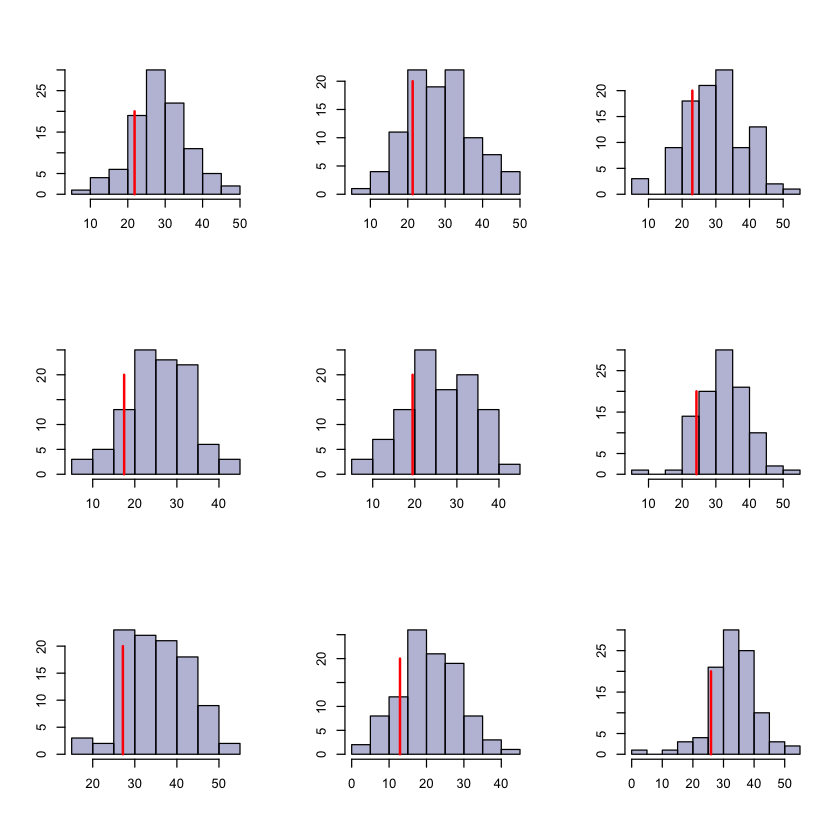

In [7]:
par(mfrow = c(3, 3))
for(i in 1:9){
    hist(as.numeric(likelihoods_distros[[i]]), main = '', ylab = '', xlab = '', col = rgb(0, 0, 0.5, 0.3))
    lines(x = c(likelihoods_empirical[i], likelihoods_empirical[i]), y = c(0, 20), col = 'red', lwd = 2)
}

**Figure 1.** The histograms correspond to the likelihoods of the simulated trees. The red vertical line is the likelihood of the 'empirical' tree.

- In this case, the P values are consistently at the lower end of the distribution, compared to when the data were analysed using the corect model. However, they still don't reject the model.

In [9]:
pvals

[1] 15 25 20 13 18 11 14 19 12 16